In [1]:
using Pkg
Pkg.add("TestImages")

   Updating registry at `C:\Users\i am\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\i am\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\i am\.julia\environments\v1.5\Manifest.toml`


In [1]:
using ArchGDAL, CSV, DataFrames
using ImageTransformations, CoordinateTransformations, Rotations, Plots

In [2]:
function closest_index(x::Array{T,1}, val::Q) where {T <: Number, Q <: Number}
    ibest = 1
    dxbest = abs(x[ibest]-val)
    for I in 1:length(x)
        dx = abs(x[I]-val)
        if dx < dxbest
            dxbest = dx
            ibest = I
        end
    end
    ibest
end
function closest_index(x::Array{T,1}, val::Array{Q,1}) where {T <: Number, Q <: Number}
    [closest_index(x,val[i]) for i in 1:length(val)]
end
function resize_cube(cube::Array{T,3},ratio) where T
	band1 = imresize(cube[:,:,1],ratio=ratio)
	cubeR = Array{typeof(band1[1]),3}(
		undef, 
		size(band1)[1],
		size(band1)[2],
		size(cube)[3]
	)
	cubeR[:,:,1]=band1
	for i in 2:size(cube)[3]
		cubeR[:,:,i] = imresize(cube[:,:,i],ratio=ratio)
	end
	cubeR
end
function resize_cube(cube::Array{T,2},ratio) where T
	imresize(cube,ratio=ratio)
end
function get_ranges(cube)
	minimums = Array{typeof(cube[1]),1}(undef,size(cube)[3])
	maximums = Array{typeof(cube[1]),1}(undef,size(cube)[3])
	for i in 1:size(cube)[3]
        try
            minimums[i] = minimum(filter(!iszero,cube[:,:,i]))
            #above errors if all elements are 0
        catch e
            println(e)
            minimums[i] = 0
        end            
		maximums[i] = maximum(cube[:,:,i])
	end
	[(minimums[i],maximums[i]) for i in 1:length(maximums)]
end

get_ranges (generic function with 1 method)

In [3]:
function fix_points(first_e::Array{Array{Int,1},1})
    # find usable points
    usable = [true for _ in first_e]
    max_width = maximum([i[2] for i in first_e])
    max_height = maximum([i[1] for i in first_e])
    for i in 1:length(first_e)
        if first_e[i][1] == max_height || first_e[i][1] == 1
            if first_e[i][2] == max_width || first_e[i][2] == 1
                usable[i] = false
            end
        end 
    end
    
    fixed = true
    #fixing A
    if !usable[1]
        if !usable[4]
            fixed = false
        else
            first_e[1][2] = max_width - first_e[3][2]
        end
    end
    #fixing B
    if !usable[2]
        if !usable[3]
            fixed = false
        else
            first_e[2][1] = max_height - first_e[3][1]
        end
    end    
    #fixing C
    if !usable[3]
        if !usable[2]
            fixed = false
        else
            first_e[3][1] = max_height - first_e[2][1]
        end
    end
    #fixing D
    if !usable[4]
        if !usable[1]
            fixed = false
        else
            first_e[4][2] = max_width - first_e[1][2]
        end
    end
    first_e
end

fix_points (generic function with 1 method)

In [4]:
function find_points_of_square(band::Array{T,2}) where T
	#A B
	#C D
	width = size(band)[2]
	height = size(band)[1]
	##########################	A
	i = 1
	found = false
	while i<width && !found
		if !M_iszero(band[1,i])
			found = true
		else
			i = i+1
		end
	end
	A = [1,i]
	##########################	B
	i = 1
	found = false
	while i<height && !found
		if !M_iszero(band[i,width])
			found = true
		else
			i = i+1
		end
	end
	B = [i, width]
	##########################	C
	i = 1
	found = false
	while i>height && !found
		if !M_iszero(band[i,1])
			found = true
		else
			i = i+1
		end
	end
	C = [height,i]
	##########################	D
	i = 1
	found = false
	while i<width && !found
		if !M_iszero(band[height,i])
			found = true
		else
			i = i+1
		end
	end
	D = [height,i]
	[A, B, C, D]
end
function find_points_of_square(cube::Array{T,3}) where T
	[find_points_of_square(cube[:,:,i]) for i in 1:size(cube)[3]]
end

find_points_of_square (generic function with 2 methods)

In [13]:
function calc_angle(points::Array{Array{Int,1},1})
    opposite = points[1][2]
    adjacent = points[3][1]
    cot(opposite/adjacent)
end
function tilt_band(first_e, img)
    max_width = maximum(first_e[:][2])
    opposite = first_e[1][2] - max_width
    adjacent = first_e[2][1]
    angle = cot(opposite/adjacent)
    # define transformation
    trfm = recenter(RotMatrix(angle/π), ImageTransformations.center(img))
    collect(warp(img, trfm))
end

tilt_band (generic function with 1 method)

In [6]:
function M_iszero(x)
    iszero(x) || isnan(x)
end
function crop_out_zeros(band::Array{T,2}) where T
    width = size(band)[2]
    height = size(band)[1]
    #1 find how many rows we snip from 0
    UProws = 0
    i=1
    found= false
    while !found
        if count(!M_iszero,band[i,:])>0
            found = true
            UProws = i
        else
            i = i+1
        end
    end
    #2 find rows to snip from the bottom
    DOrows=0
    i=0
    found= false
    while !found
        if count(!M_iszero,band[height-i,:])>0
            found = true
            DOrows = i
        else
            i = i + 1
        end
    end
    #3 find cols to snip from the left
    Lcols=0
    i=1
    found= false
    while !found
        if count(!M_iszero,band[:,i])>0
            found = true
            Lcols = i
        else
            i = i+1
        end
    end
    #4 find cols to snip from the right
    Rcols=0
    i=0
    found= false
    while !found
        if count(!M_iszero,band[:,width-i])>0
            found = true
            Rcols = i
        else
            i = i+1
        end
    end
    #4 get cropped band
    band[UProws:(height-DOrows),Lcols:(width-Rcols)]
end

crop_out_zeros (generic function with 1 method)

In [7]:
function find_first(arr::Array{T,1}, f; reverse=false) where T
    len = length(arr)
    if reverse
        i = len
        while f(arr[i]) && i > 0
            i = i - 1
        end
    else
        i = 1
        while f(arr[i]) && i <= len
            i = i + 1
        end       
    end
    i
end
function find_lengths(band::Array{T,2}, f ; rows = true) where T
    if rows
        lengths = Array{Int,1}(undef, size(band)[1])
        for i in length(lengths)
            lengths[i] = find_first(band[i,:], f; reverse=true)-find_first(band[i,:], M_iszero) +  1
        end
    else
        lengths = Array{Int,1}(undef, size(band)[2])
        for i in length(lengths)
            lengths[i] = find_first(band[:,i], f; reverse=true)-find_first(band[:,i], M_iszero) +  1
        end
    end
    lengths
end
function NaN_zeros!(band)
    for i in 1:length(band)
        if band[i] == 0
            band[i] = NaN
        end
    end
    band
end
function zero_NaNs(band)
    for i in 1:length(band)
        if isnan(band[i])
            band[i] = 0
        end
    end
    band
end

zero_NaNs (generic function with 1 method)

In [8]:
function plot_cols(band)
    p = plot(legend=false)
    for i in 1:size(band)[2]
        plot!(filter(!iszero, band[:,i]))
    end
    p
end 

plot_cols (generic function with 1 method)

In [9]:
function plot_rows(band)    
    p = plot(legend=false)
    for i in 1:size(band)[1]        
        plot!(filter((x)->(x[2]!=0), [(band[i,j], j) for j in 1:length(band[i,:])]))
    end
    p
end

plot_rows (generic function with 1 method)

In [16]:
function _preliminary(band)
    # 1 crop
    band = crop_out_zeros(band)
    # 2 find points
    points = fix_points(find_points_of_square(band))
    # 3 tilt
    zero_NaNs(crop_out_zeros(tilt_band(points, band)))
end

_preliminary (generic function with 1 method)

In [10]:
function plot_band(band)    
    # 4 resize
    band = imresize(_preliminary(band), ratio = 1/20)
    # 5 define plots
    hm = heatmap(band)
    
    rowp = plot_rows(band)
    
    colp = plot_cols(band)
    
    pad = plot()
    
    plot(colp, pad, hm, rowp)
end

plot_band (generic function with 1 method)

In [11]:
wvls = CSV.read("out/profiler_test_VNIR.wvl", DataFrame)
# parameters
tiff = "out/profiler_test_VNIR.tif"
bands = [4,5,6,7,8,9,10,55,21]
#####
dataset = ArchGDAL.read(tiff)
cube = Array{typeof(ArchGDAL.getband(dataset, 1)[1,1]),3}(
	undef,
	ArchGDAL.width(dataset),
	ArchGDAL.height(dataset), 
	length(bands)
)
for i in 1:length(bands)
	global cube[:,:,i] = ArchGDAL.getband(dataset, bands[i])
end

In [15]:
typeof(plot_band(cube[:,:,3]))

Plots.Plot{Plots.GRBackend}

In [51]:
function plot_linewise(cube::Array{T,3}) where T
    plots = Array{Plots.Plot,1}(undef,size(cube)[3])
    for band_i in 1:size(cube)[3]
        b = imresize(_preliminary(cube[:,:,band_i]), ratio = 1/20)
        plots[band_i] = plot(reshape(b, length(b)), legend= false, title="band $band_i", xlabel="column", ylabel="value") 
    end 
    plot(plots...)
end

plot_linewise (generic function with 2 methods)

In [52]:
function plot_linewise(band::Array{T,2}) where T
    b = imresize(_preliminary(band), ratio = 1/20)
    plot(reshape(b, length(b)), legend= false)  
end

plot_linewise (generic function with 2 methods)

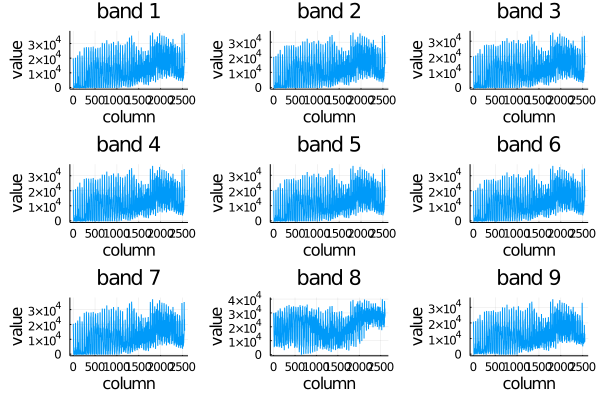

In [53]:
plot_linewise(cube)

In [56]:
heatmap(_preliminary(cube[:,:,8]))

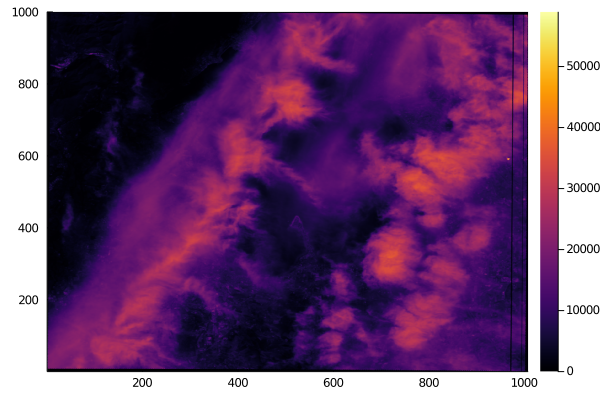

In [57]:
heatmap(_preliminary(cube[:,:,9]))